In [1]:
import tensorflow as tf
import keras
from keras.layers import Input ,Dense, Dropout, Activation, LSTM
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Reshape, BatchNormalization, Add
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Model
from keras.optimizers import Adam
from keras.engine.network import Network
from keras import backend as K

import keras.backend.tensorflow_backend as KTF

from keras.initializers import glorot_normal,orthogonal

from keras.callbacks import EarlyStopping,TensorBoard
import csv

from PIL import Image

%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import cv2
import os
import random

from tqdm import tqdm

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# sess = tf.Session(config=config)
# K.set_session(sess)


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
K.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#どんくらいで学習させるか関連
timesteps=10 #一回のLSTMに入れる値の数
camera=5 #カメラの数

rate = 5 #飛ばすフレーム数（30FPSを30/rateのFPSの動画に疑似変換する．）

#画像関連 
channels=3
img_width=50
img_height=50

#LSTMなどで用いる値
epochs = 100 # エポック数 
batch_size = 5 # バッチサイズ

In [3]:
class DataLoader:
    def __init__(self, camera_num, file_name, timesteps, width, height):
        self.camera_num = camera_num
        self.file_name =file_name
        self.samples=0
        self.timesteps=timesteps
        self.width=width
        self.height=height
        self.save_numpy()
        
    def save_numpy(self):
        self.samples = int(self.get_sample()/rate)
        if not (os.path.isfile(self.file_name+"label_"+str(rate)+".npy")):
            self.make_numpy_learnData()
            self.make_numpy_labelData()
        self.learnData=np.load(self.file_name+"learn_"+str(rate)+".npy")
        self.labelData=np.load(self.file_name+"label_"+str(rate)+".npy")
    
    def get_sample(self):
        video_path = self.file_name+"video/0.mp4"
        cap = cv2.VideoCapture(video_path)
        num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        return num
    
    def make_numpy_labelData(self):
        labelData=[]
        csv_selection=csv.reader(open(self.file_name+"video/mintime_optimize.csv", 'r'))
        one_hot = np.eye(self.camera_num)
        for i,row2 in enumerate(csv_selection):
            if(i%rate==0 and i > (self.timesteps-1)*rate-1):
                labelData.append(one_hot[int(row2[1])])
        tmp_list = np.array(labelData)
        tmp_list = tmp_list.astype(np.float)
        np.save(self.file_name+"label_"+str(rate)+".npy", tmp_list)
        print(tmp_list.shape)
    
    
    def make_numpy_learnData(self):
        learnData=[]
        for i in range(0, self.camera_num):
            print()
            img_list=[]
            video_path = self.file_name+"video/"+str(i)+".mp4"
            cap = cv2.VideoCapture(video_path)
            video_len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            for j in range(0,video_len):
                
                pro_size=20
                bar = int(j*pro_size/video_len)
                pro_bar = ('=' * bar) + (' ' * (pro_size - bar))
                percent ='{:03f}'.format(j / video_len * 100.)
                print('\r{0}/{1} [{2}] {3}%'.format((i+1), self.camera_num, pro_bar, percent), end='')
                
                ret, frame = cap.read()
                if(j%rate==0):
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    img=Image.fromarray(frame)
                    img = img.resize((self.width, self.height))
                    x = np.array(img, dtype=np.float32)
                    x = x / 255.
                    img_list.append(x)
            learnData.append(img_list)
            
        tmp_list=np.array(learnData)
        tmp_list=tmp_list.astype(np.float)
        np.save(self.file_name+"learn_"+str(rate)+".npy", tmp_list)
        print(tmp_list.shape)
    
    
    def make_learndata(self, num=[]):
        data_name=self.file_name+"learn_0_"+str(rate)+".npy"
        if (os.path.isfile(data_name)):
            test=np.load(data_name)
        else:
            all_list = [np.empty((0,self.timesteps, self.width, self.height, 3), np.float)]*self.camera_num
            tmp_list = [np.empty((0,self.timesteps, self.width, self.height, 3), np.float)]*self.camera_num
            for i in range(0, self.labelData.shape[0]):
                #まずはすべての分だけ回す
                pro_size=20
                bar = int(i*pro_size/self.labelData.shape[0])
                pro_bar = ('=' * bar) + (' ' * (pro_size - bar))
                percent ='{:03f}'.format(i / self.labelData.shape[0] * 100.)
                print('\r [{0}] {1}%'.format(pro_bar, percent), end='')
                
                count=num[np.argmax(self.labelData[i,:])]
                
                for j in range(0,count):
                    #dataAugumentationする分だけ回す
                    #dataAugmentationは異なるカメラでも同じ時間軸の場合同じ角度で回したいため，はじめに角度を取得する．
                    random_angle = float(random.randint(0,180))
                    
                    for camera in range(0, self.camera_num):
                        #カメラの台数だけ回す
                        #tmp_list[camera]の同じ引数（番号）には角度を同じ分だけずらした同じ時間軸のsequenceが入っている．
                        first_list =np.empty((0, self.width, self.height, 3), np.float)
                        for l in range(0, self.timesteps):
                            #timesteps分のndarrayを作る．
                            tmp_img=self.learnData[camera,i+l]
                            img = self.augumentation(tmp_img, random_angle)
                            first_list =np.append(first_list, [img], axis=0)
                        #あるカメラについて，１つのsequenceがfirst_listに出来上がっている状態．
                        tmp_list[camera]=np.append(tmp_list[camera], [first_list], axis=0)
                if(tmp_list[0].shape[0]>100 or i == self.labelData.shape[0]-1):
                    #処理時間短縮のため，sequenceがtmp_listに溜まってきたら，全体に統合してまたtmp_listを初期化する．
                    for camera in range(0, self.camera_num):
                        all_list[camera]=np.append(all_list[camera], tmp_list[camera], axis=0)
                        tmp_list[camera] = np.empty((0,self.timesteps, self.width, self.height, 3), np.float)
            
            for camera in range(0, self.camera_num):
                print(all_list[camera].shape)
                data_name=self.file_name+"learn_"+str(camera)+"_"+str(rate)
                np.save(data_name, all_list[camera])
                del all_list[camera]
    
    
    def make_labeldata(self, num=[]):
        data_name=self.file_name+"final_label_"+str(rate)+"_.npy"
        if (os.path.isfile(data_name)):
            test=np.load(data_name)
        else:
            test = np.empty((0,5), np.float)
            for i in range(0,self.labelData.shape[0]):
                count=num[np.argmax(self.labelData[i,:])]
                for j in range(0, count):
                    test = np.append(test, [self.labelData[i]], axis=0)
            print(test.shape)
            np.save(data_name, test)
    
    
    def get_learndata(self, num):
        data_name=self.file_name+"learn_"+str(num)+"_"+str(rate)+".npy"
        test=np.load(data_name)
        return test
    
    def get_labeldata(self):
        data_name=self.file_name+"final_label_"+str(rate)+"_.npy"
        test=np.load(data_name)
        return test
    
    
    def augumentation(self, img, num):
        height = img.shape[0]                
        width = img.shape[1]                       
        center = (int(width/2), int(height/2))
        angle = num
        scale = 1.0
        trans = cv2.getRotationMatrix2D(center, angle , scale)
        image2 = cv2.warpAffine(img, trans, (width,height))
        return image2
        
    
    def show(self):
        print(0,self.get_learndata(0).shape)
        print(1,self.get_learndata(1).shape)
        print(2,self.get_learndata(2).shape)
        print(3,self.get_learndata(3).shape)
        print(4,self.get_learndata(4).shape)
        print(self.get_labeldata().shape)

In [4]:
data = DataLoader(camera, "./data/20190426/", timesteps, img_width, img_height)
aug_rate=[3,7,7,2,1]
data.make_learndata(aug_rate)
data.make_labeldata(aug_rate)
data.show()

0 (1687, 10, 50, 50, 3)
1 (1687, 10, 50, 50, 3)
2 (1687, 10, 50, 50, 3)
3 (1687, 10, 50, 50, 3)
4 (1687, 10, 50, 50, 3)
(1687, 5)


In [5]:
### add for TensorBoard

old_session = KTF.get_session()
session = tf.Session('')
KTF.set_session(session)
KTF.set_learning_phase(1)

In [6]:
class Resnet18 :
    ##
    ##　Resnet-18の作成
    ##
    def __init__(self, width, height, channels):
        self.img_rows=height
        self.img_cols=width
        self.img_channels=channels
    
    def rescell(self, data, filters, kernel_size, option=False):
        strides=(1,1)
        if option:
            strides=(2,2)
        x=Convolution2D(filters=filters,kernel_size=kernel_size,strides=strides,padding="same")(data)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        
        data=Convolution2D(filters=int(x.shape[3]), kernel_size=(1,1), strides=strides, padding="same")(data)
        x=Convolution2D(filters=filters,kernel_size=kernel_size,strides=(1,1),padding="same")(x)
        x=BatchNormalization()(x)
        x=Add()([x,data])
        x=Activation('relu')(x)
        
        return x
    
    def create_resnet18(self):
        inputs=Input(shape=(self.img_rows, self.img_cols, self.img_channels))
        x=Convolution2D(64,(7,7), padding="same", input_shape=(self.img_rows, self.img_cols),activation="relu")(inputs)
        x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)

        x=self.rescell(x,64,(3,3))
        x=self.rescell(x,64,(3,3))
        x=self.rescell(x,64,(3,3))
        
        x=self.rescell(x,128,(3,3),True)
        x=self.rescell(x,128,(3,3))

        x=self.rescell(x,256,(3,3),True)
        x=self.rescell(x,256,(3,3))
        
        x=self.rescell(x,512,(3,3),True)
        x=self.rescell(x,512,(3,3))
        
        model=Model(inputs=inputs,outputs=[x])
        return model

    def get_resnet18(self):
        return self.create_resnet18()

In [7]:
class Prediction :
    def __init__(self, timesteps, n_out, width, height):
        self.maxlen = timesteps
        self.n_out = n_out
        self.width=width
        self.height=height
        self.resnet = Resnet18(width, height, 3).get_resnet18()
        self.sharedLayer = self.create_sharedmodel()
    
    
    def create_sharedmodel(self):
        inputs = Input(shape=(self.maxlen, self.height, self.width, 3))
        
        x = TimeDistributed(self.resnet,name="resnet")(inputs)
        x = TimeDistributed(GlobalAveragePooling2D(), name="GAP")(x)
        x = TimeDistributed(Dense(512,activation='relu'), name="dense")(x)
        predictions = LSTM(256, batch_input_shape = (None, self.maxlen, 512),
             kernel_initializer = glorot_normal(seed=20181020),
             recurrent_initializer = orthogonal(gain=1.0, seed=20181020), 
             dropout = 0.01, 
             recurrent_dropout = 0.01)(x)
        
        shared_layers = Model(inputs, predictions, name="shared_layers")
        
        return shared_layers
    
    
    def create_model(self):
        model_input1 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input2 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input3 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input4 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input5 = Input(shape=(self.maxlen, self.height, self.width, 3))
        
        mid_feature1 = self.sharedLayer(model_input1)
        mid_feature2 = self.sharedLayer(model_input2)
        mid_feature3 = self.sharedLayer(model_input3)
        mid_feature4 = self.sharedLayer(model_input4)
        mid_feature5 = self.sharedLayer(model_input5)
        
        merged_vector = keras.layers.concatenate([mid_feature1, mid_feature2, mid_feature3, mid_feature4, mid_feature5], axis=-1)
        mid_dense = Dense(256, activation='relu')(merged_vector)
        predictions = Dense(self.n_out, activation='softmax')(mid_dense)
        
        model = Model(inputs=[model_input1, model_input2, model_input3, model_input4, model_input5], outputs=predictions)
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    
    def train(self, x_train, t_train, x_vali, t_vali, batch_size, epochs) :
        early_stopping = EarlyStopping(patience=20, verbose=1)
        tb_cb = TensorBoard(log_dir="./data/20190426/tflog/", histogram_freq=1)
        model = self.create_model()
        hist = model.fit(x=[x_train[0], x_train[1], x_train[2], x_train[3], x_train[4]], y=t_train, batch_size = batch_size, epochs = epochs, validation_data=([x_vali[0], x_vali[1], x_vali[2], x_vali[3], x_vali[4]], t_vali), callbacks = [early_stopping])
        return model, hist
    
    
    def train_keras(self, x_train, t_train, batch_size, epochs) :
        early_stopping = EarlyStopping(patience=20, verbose=1)
        tb_cb = TensorBoard(log_dir="./data/20190426/tflog/", histogram_freq=1, write_graph=True, write_grads=True)
        model = self.create_model()
        hist = model.fit([x_train[0], x_train[1], x_train[2], x_train[3], x_train[4]], t_train, batch_size = batch_size, epochs = epochs, verbose = 1,
                         callbacks = [early_stopping], validation_split = 0.2)
        return model, hist

In [8]:
# モデル定義
pred = Prediction(timesteps, camera, img_width, img_height)
model = pred.create_model()
print(model.summary())








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 50, 50, 3 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 50, 50, 3 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 10, 50, 50, 3 0                                            
_________________________________________________________________________________________

In [9]:
from tqdm import tqdm
test_learn=[np.empty((data.get_labeldata().shape[0],10, 50, 50, 3), np.float)]*camera
vali_learn=[np.empty((0,10, 50, 50, 3), np.float)]*camera
test_label=data.get_labeldata()
vali_label=np.empty((0,camera), np.float)

print(test_label.shape)

for j in range(0,camera):
    test_learn[j]=data.get_learndata(j)

# for i in tqdm(range(0,int(0.1*test_label.shape[0]))):
#     random_angle = int(random.randint(0,test_label.shape[0]-1))
#     for j in range(0,camera):
#         vali_learn[j]=np.append(vali_learn[j], [test_learn[j][random_angle]],axis=0)
#         test_learn[j]=np.delete(test_learn[j], random_angle,0)
#     vali_label=np.append(vali_label, [test_label[random_angle]], axis=0)
#     test_label=np.delete(test_label, random_angle,0)

(1687, 5)


In [11]:
# 学習
#model , hist = pred.train(test_learn, test_label, vali_learn, vali_label, batch_size, epochs)
model , hist = pred.train_keras(test_learn, test_label, batch_size, epochs)
# テスト
score = model.evaluate(test_learn, test_label, batch_size = batch_size, verbose = 1)
print("score:", score)


# ### add for TensorBoard
# KTF.set_session(old_session)
# ###


# -------------------------------------------------------------------------------------
#                            モデルのアーキテクチャの保存
# -------------------------------------------------------------------------------------
# モデルのアーキテクチャの保存①(JSON版)
model_arc_json = model.to_json()
open("model_architecture.json", mode='w').write(model_arc_json)


# -------------------------------------------------------------------------------------
#                            　　モデルの重みの保存
# -------------------------------------------------------------------------------------
# モデルの重みの保存
model.save_weights("weights.hdf5")



Train on 1349 samples, validate on 338 samples
Epoch 1/100
1349/1349 [==============================] - 94s 69ms/step - loss: 0.4341 - acc: 0.8132 - val_loss: 0.4782 - val_acc: 0.7988
Epoch 2/100
1349/1349 [==============================] - 76s 56ms/step - loss: 0.2648 - acc: 0.8904 - val_loss: 0.6119 - val_acc: 0.7550
Epoch 3/100
1349/1349 [==============================] - 75s 56ms/step - loss: 0.1798 - acc: 0.9253 - val_loss: 0.7329 - val_acc: 0.7325
Epoch 4/100
1349/1349 [==============================] - 76s 57ms/step - loss: 0.1067 - acc: 0.9579 - val_loss: 0.8934 - val_acc: 0.7296
Epoch 5/100
1349/1349 [==============================] - 74s 55ms/step - loss: 0.0916 - acc: 0.9655 - val_loss: 0.9247 - val_acc: 0.7544
Epoch 6/100
1349/1349 [==============================] - 76s 57ms/step - loss: 0.0606 - acc: 0.9800 - val_loss: 1.2968 - val_acc: 0.7041
Epoch 7/100
1349/1349 [==============================] - 73s 54ms/step - loss: 0.0523 - acc: 0.9818 - val_loss: 1.2842 - val_acc:

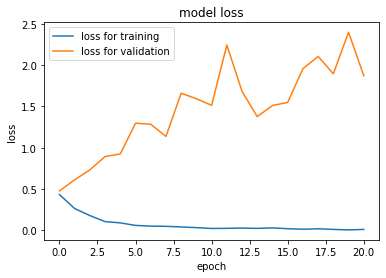

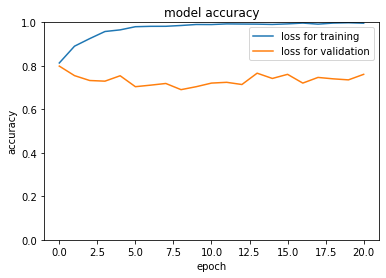

In [12]:
def plot_history_loss(hist):
    # 損失値(Loss)の遷移のプロット
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

def plot_history_acc(hist):
    # 精度(Accuracy)の遷移のプロット
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

In [15]:
model.save('model_1.h5', include_optimizer=False)

In [14]:
#試すやつ！

pre = [[0 for i in range(5)] for j in range(5)]
print(test_learn[0].shape)
# 正答率集計
preds = model.predict([test_learn[0], test_learn[1], test_learn[2], test_learn[3], test_learn[4]])
correct = 0

f = open("./data/20190426/result.csv", 'w')
writer = csv.writer(f)
for i in range(0,timesteps):
    writer.writerow([0])

for i in range(len(preds)):
    pred_result = np.argmax(preds[i,:])
    tar = np.argmax(data.get_labeldata()[i,:])
    for j in range(0,rate):
        writer.writerow([pred_result])
    pre[pred_result][tar]+=1
    print(pred_result, tar)
    if pred_result == tar :
        correct += 1

print("正答率:", 1.0 * correct / len(preds))

(1687, 10, 50, 50, 3)
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
3 0
3 0
3 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
3 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
0 4
4 4
4 4
3 4
3 4
3 4
4 4
4 4
0 4
1 4
4 4
4 4
4 4
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
4 4
4 4
0 4
4 4
0 4
4 4
4 4
4 4
0 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 

In [16]:
class DataLoader2:
    def __init__(self, camera_num, file_name, timesteps, width, height):
        self.camera_num = camera_num
        self.file_name =file_name
        self.samples=0
        self.timesteps=timesteps
        self.width=width
        self.height=height
        self.caps=[]
        self.save_numpy()
        
    def save_numpy(self):
        for i in range(0,self.camera_num):
            video_path = self.file_name+"video/"+str(i)+".mp4"
            self.caps.append(cv2.VideoCapture(video_path))
            
        self.video_len = int(self.caps[0].get(cv2.CAP_PROP_FRAME_COUNT))
            
        if not (os.path.isfile(self.file_name+"test_"+str(rate)+".npy")):
            self.make_numpy_testData()
        self.learnData=np.load(self.file_name+"test_"+str(rate)+".npy")
        print(self.learnData.shape[1])
        
        
    def make_numpy_testData(self):
        learnData=[]
        for i in range(0, self.camera_num):
            print()
            img_list=[]
            for j in range(0,self.video_len):
                
                pro_size=20
                bar = int(j*pro_size/self.video_len)
                pro_bar = ('=' * bar) + (' ' * (pro_size - bar))
                percent ='{:03f}'.format(j / self.video_len * 100.)
                print('\r{0}/{1} [{2}] {3}%'.format((i+1), self.camera_num, pro_bar, percent), end='')
                
                ret, frame = self.caps[i].read()
                if(j%rate==0):
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    img=Image.fromarray(frame)
                    img = img.resize((self.width, self.height))
                    x = np.array(img, dtype=np.float32)
                    x = x / 255.
                    img_list.append(x)
            learnData.append(img_list)
            
        tmp_list=np.array(learnData)
        tmp_list=tmp_list.astype(np.float)
        np.save(self.file_name+"test_"+str(rate)+".npy", tmp_list)
        print(tmp_list.shape)
    
        
    def make_learndata(self):
        data_name=self.file_name+"test_0_"+str(rate)+".npy"
        if (os.path.isfile(data_name)):
            test=np.load(data_name)
        else:
            all_list = [np.empty((0,self.timesteps, self.width, self.height, 3), np.float)]*self.camera_num
            tmp_list = [np.empty((0,self.timesteps, self.width, self.height, 3), np.float)]*self.camera_num
            for i in range(0, self.learnData.shape[1]-self.timesteps):
                
                #まずはすべての分だけ回す
                pro_size=20
                bar = int(i*pro_size/self.learnData.shape[1])
                pro_bar = ('=' * bar) + (' ' * (pro_size - bar))
                percent ='{:03f}'.format(i / self.learnData.shape[1] * 100.)
                print('\r [{0}] {1}%'.format(pro_bar, percent), end='')
                
                for camera in range(0, self.camera_num):
                    #カメラの台数だけ回す
                    #tmp_list[camera]の同じ引数（番号）には角度を同じ分だけずらした同じ時間軸のsequenceが入っている．
                    first_list =np.empty((0, self.width, self.height, 3), np.float)
                    for l in range(0, self.timesteps):
                        #timesteps分のndarrayを作る．
                        img=self.learnData[camera,i+l]
                        first_list =np.append(first_list, [img], axis=0)
                    #あるカメラについて，１つのsequenceがfirst_listに出来上がっている状態．
                    tmp_list[camera]=np.append(tmp_list[camera], [first_list], axis=0)
                    
                if(tmp_list[0].shape[0]>100 or i == self.learnData.shape[1]-self.timesteps-1):
                    #処理時間短縮のため，sequenceがtmp_listに溜まってきたら，全体に統合してまたtmp_listを初期化する．
                    for camera in range(0, self.camera_num):
                        all_list[camera]=np.append(all_list[camera], tmp_list[camera], axis=0)
                        tmp_list[camera] = np.empty((0,self.timesteps, self.width, self.height, 3), np.float)
            
            for camera in range(0, self.camera_num):
                print(all_list[camera].shape)
                data_name=self.file_name+"test_"+str(camera)+"_"+str(rate)
                np.save(data_name, all_list[camera])
    
    
    def get_testdata(self, num):
        data_name=self.file_name+"test_"+str(num)+"_"+str(rate)+".npy"
        test=np.load(data_name)
        return test
    
    def get_image(self, camera_num, frame_num):    
        self.caps[camera_num].set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = self.caps[camera_num].read()
        return frame
    
    def show(self):
        print(0,self.get_testdata(0).shape)
        print(1,self.get_testdata(1).shape)
        print(2,self.get_testdata(2).shape)
        print(3,self.get_testdata(3).shape)
        print(4,self.get_testdata(4).shape)

        
data1 = DataLoader2(camera, "./data/20190426/", timesteps, img_width, img_height)
data1.make_learndata()
data1.show()

test_learn1=[np.empty((data1.get_testdata(0).shape[0],10, 50, 50, 3), np.float)]*camera
for j in range(0,camera):
    test_learn1[j]=data1.get_testdata(j)

print(test_learn1[0].shape)

# 正答率集計
preds = model.predict([test_learn1[0], test_learn1[1], test_learn1[2], test_learn1[3], test_learn1[4]])
correct = 0

f = open("./data/20190426/result_2.csv", 'w')
writer = csv.writer(f)

for i in range(0,timesteps*rate):
    writer.writerow([0])

for i in range(len(preds)):
    pred_result = np.argmax(preds[i,:])
    for j in range(0,rate):
        writer.writerow([pred_result])
    print(pred_result, tar)

751
0 (741, 10, 50, 50, 3)
1 (741, 10, 50, 50, 3)
2 (741, 10, 50, 50, 3)
3 (741, 10, 50, 50, 3)
4 (741, 10, 50, 50, 3)
(741, 10, 50, 50, 3)
3 2
0 2
0 2
0 2
0 2
0 2
3 2
3 2
3 2
3 2
3 2
3 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
0 2
0 2
0 2
0 2
0 2
1 2
1 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
3 2
4 2
4 2
0 2
1 2
4 2
4 2
4 2
3 2
3 2
3 2
3 2
3 2
3 2
4 2
4 2
0 2
4 2
0 2
0 2
4 2
0 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
4 2
4 2
4 2
4 2
3 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
2 2
2 2
2 2
2 2
2 2
2 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
3 2
3 2
4 2
4 2
3 2
3 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
3 2
4 2
4 2
4 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
3 2
3 2
3 2
3 2
3 2
3 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
3 2
3 2
3 2
3 2
3 2
3 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
4 2
3 2
